### Import libraries

In [1]:
import sys
sys.path.insert(0, '../backend')
sys.path.insert(0, '../data')

import numpy as np
import matplotlib.pyplot as plt
from fbm import FBM
import iisignature
from transformers import *
# from bnb_warping_pvar import BnBWarping
import KNN_algo
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import importlib
import pandas as pd
from collections import defaultdict
import random
import math
import pybnb
from transformers import *

from sklearn import decomposition
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.manifold import MDS, TSNE
from sklearn import metrics

import plotly.plotly as py
import plotly.graph_objs as go
import plotly

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
%matplotlib inline

In [2]:
def print_results(n_clusters_, labels_true, labels):
    print('Estimated number of clusters: %d' % n_clusters_)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))

In [3]:
def sig_path(x, p, width):
    return np.concatenate([np.zeros(iisignature.siglength(width, int(p))).reshape(1, -1), iisignature.sig(x, int(p), 2)])

def inverse_sig_path(path, p):
    s = []
    for i in range(len(path)):
        s.append(iisignature.sig(path[:i+1][::-1], int(p)))
    return np.array(s)

In [4]:
# def warping_pvar(x, y, x_inv, y_inv, p, width, bc=4, rough_path=True):
#     problem = BnBWarping(x=x, x_inv=x_inv, y=y, y_inv=y_inv, p=p, norm='l2', bc=bc, width=width, rough_path=rough_path)
#     solver = pybnb.Solver()
#     results = solver.solve(problem, log=None, queue_strategy='depth', time_limit=5, node_limit=1000, queue_tolerance=1e-6,)
#     return results.objective

In [5]:
# def white(steps, width, time=1.):
#     mu, sigma = 0, math.sqrt(time / steps) 
#     return np.random.normal(mu, sigma, (steps, width))

# def brownian(steps, width, time=1.):
#     path = np.zeros((steps + 1, width))
#     np.cumsum(white(steps, width, time), axis=0, out=path[1:, :])
#     return path

# k-Menoids clustering function

In [6]:
def cluster(distances, k=3):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)
   
    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

# fBM paths generation

In [7]:
# number of clusters
k = 3

# hurst exponents
hursts = np.linspace(0.1, 0.5, k)

# number of paths per cluster
N = 5

paths = []
labels = []

for h in hursts:
    for i in range(N):
        f = FBM(np.random.randint(110, 120),h)
        paths.append(f.fbm())
        labels.append(h)
        
paths = np.array(paths)
labels = np.array(labels)

# Clustering fractional Brownian Motion sample paths

### Precompute DTW pairwise distances matrix

In [8]:
dtw_algo = KNN_algo.KnnEstimator('dtw', width=None, subsample_step=1, bc=None, rough_path=False)
dtw_algo.fit(paths, paths, labels)
dtw_dist_matrix = dtw_algo._dist_matrix(paths, paths, paths, paths, parallel=True)

equal size arrays


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  5.53it/s]


In [9]:
outer = {}
for i, di in enumerate(dtw_dist_matrix):
    inner = {}
    for j, dj in enumerate(di):
        inner[j] = dtw_dist_matrix[i,j]
    outer[i] = inner

In [10]:
df_dtw = pd.DataFrame.from_dict(outer).fillna(0.) + pd.DataFrame.from_dict(outer).fillna(0.).T 

### Precompute Warping $p$-variation distances matrix

In [11]:
p = 2.5

# paths_transf =  AddTime().fit_transform(LeadLag().fit_transform(paths))
paths_transf = LeadLag().fit_transform(paths)

width = paths_transf[0].shape[1]

sig_paths = np.array([sig_path(x, p, width) for x in paths_transf])
sig_paths_ = np.array([inverse_sig_path(x, p) for x in tqdm(paths_transf)])

In [12]:
importlib.reload(KNN_algo)

<module 'KNN_algo' from '../backend\\KNN_algo.py'>

In [13]:
warp_algo = KNN_algo.KnnEstimator('warping', n_neighbors=None, p=p, width=width, subsample_step=20, bc=4, rough_path=True)
warp_algo.fit(sig_paths, sig_paths_, labels)
warp_dist_matrix = warp_algo._dist_matrix(sig_paths, sig_paths, sig_paths_, sig_paths_, parallel=False)

equal size arrays


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [08:46<00:00, 16.60s/it]


In [14]:
outer_warp = {}
for i, di in enumerate(warp_dist_matrix):
    inner_warp = {}
    for j, dj in enumerate(di):
        inner_warp[j] = warp_dist_matrix[i,j]
    outer_warp[i] = inner_warp

In [15]:
df_warp = pd.DataFrame.from_dict(outer_warp).fillna(0.) + pd.DataFrame.from_dict(outer_warp).fillna(0.).T 

# 1) K-Means Clustering

In [16]:
colors = cm.rainbow(np.linspace(0, 1, k))

### DTW

Estimated number of clusters: 3
Homogeneity: 0.177
Completeness: 0.175
V-measure: 0.176


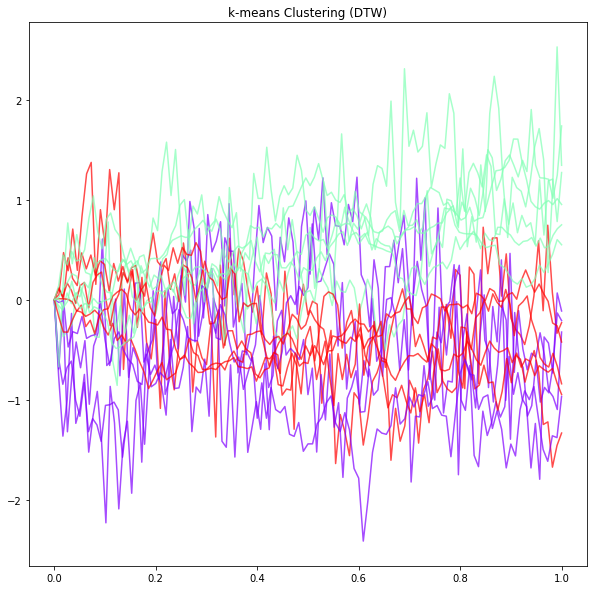

In [17]:
# compute clusters and menoids (centers)
k_menoids_clusters, k_menoids_centers = cluster(df_dtw.values, k=k)

# colors map
k_men_cluster_to_colors_dict = {}
for i, c in enumerate(np.unique(k_menoids_clusters)):
    k_men_cluster_to_colors_dict[c] = colors[i]
    
plt.figure(figsize=(10,10))
for i, (path, cluster_index, class_index) in enumerate(zip(paths, k_menoids_clusters, labels)):
    plt.plot(np.linspace(0, 1, len(path)), path, color=k_men_cluster_to_colors_dict[cluster_index], 
             label=f'class {class_index}', alpha=0.7)
    
print_results(k, k_menoids_clusters, labels)

# plt.legend()
plt.title('k-means Clustering (DTW)')
plt.show()

### Warping $p$-variation

Estimated number of clusters: 3
Homogeneity: 0.769
Completeness: 0.679
V-measure: 0.721


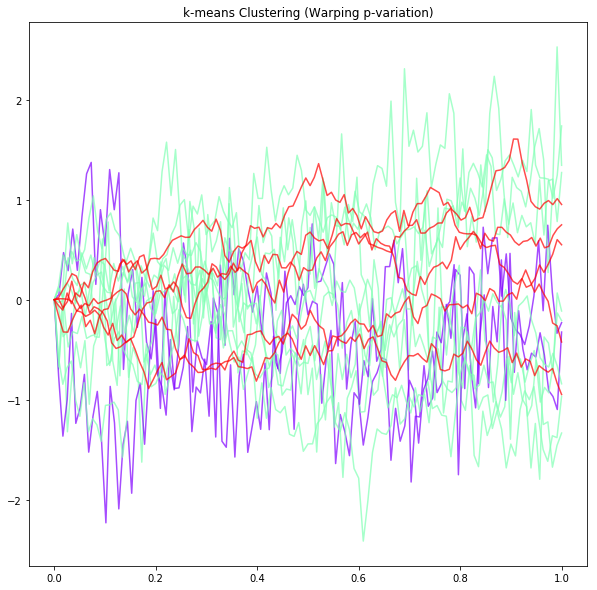

In [18]:
# compute clusters and menoids (centers)
k_menoids_clusters, k_menoids_centers = cluster(df_warp.values, k=k)

# colors map
k_men_cluster_to_colors_dict = {}
for i, c in enumerate(np.unique(k_menoids_clusters)):
    k_men_cluster_to_colors_dict[c] = colors[i]
    
plt.figure(figsize=(10,10))
for i, (path, cluster_index, class_index) in enumerate(zip(paths, k_menoids_clusters, labels)):
    plt.plot(np.linspace(0, 1, len(path)), path, color=k_men_cluster_to_colors_dict[cluster_index], 
             label=f'class {class_index}', alpha=0.7)
    
print_results(k, k_menoids_clusters, labels)

# plt.legend()
plt.title('k-means Clustering (Warping p-variation)')
plt.show()

# 2) Agglomerative Clustering

### DTW

Estimated number of clusters: 3
Homogeneity: 0.132
Completeness: 0.106
V-measure: 0.118


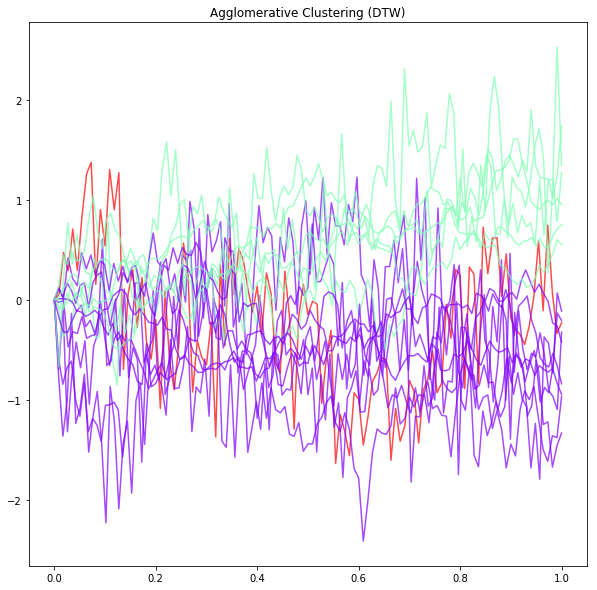

In [19]:
dtw_aggl_cluster = AgglomerativeClustering(n_clusters=k, affinity='precomputed', 
#                                            linkage='single',
#                                            linkage='complete', 
                                           linkage='average'
                                           )
dtw_aggl_cluster.fit(df_dtw.values)

# colors map
aggl_cluster_to_colors_dict = {}
for i, c in enumerate(np.unique(dtw_aggl_cluster.labels_)):
    aggl_cluster_to_colors_dict[c] = colors[i]

plt.figure(figsize=(10,10))
for i, (path, cluster_index, class_index) in enumerate(zip(paths, dtw_aggl_cluster.labels_, labels)):
    plt.plot(np.linspace(0,1, len(path)), path, color=aggl_cluster_to_colors_dict[cluster_index], 
             label=f'class {class_index}', alpha=0.7)
    
print_results(k, dtw_aggl_cluster.labels_, labels)

# plt.legend()
plt.title('Agglomerative Clustering (DTW)')
plt.show()

### Warping $p$-variation

Estimated number of clusters: 3
Homogeneity: 0.566
Completeness: 0.376
V-measure: 0.452


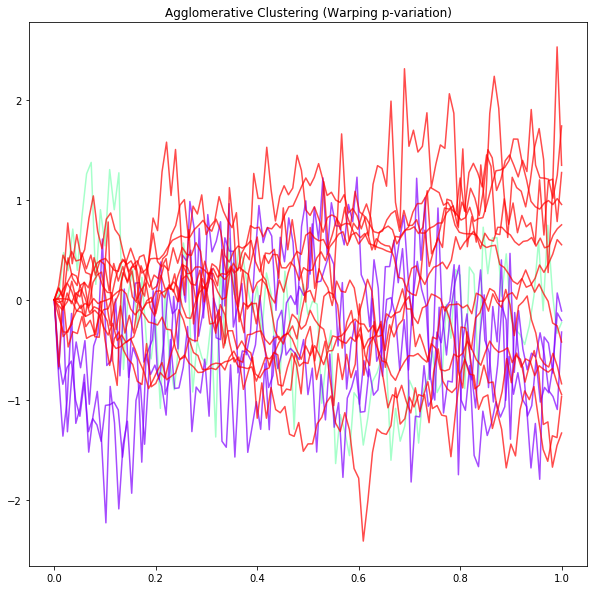

In [20]:
df_warp.replace(np.Inf, 200., inplace=True)

warp_aggl_cluster = AgglomerativeClustering(n_clusters=k, affinity='precomputed', 
#                                            linkage='single',
#                                            linkage='complete', 
                                           linkage='average'
                                           )
warp_aggl_cluster.fit(df_warp.values)

# colors map
aggl_cluster_to_colors_dict = {}
for i, c in enumerate(np.unique(warp_aggl_cluster.labels_)):
    aggl_cluster_to_colors_dict[c] = colors[i]
    
plt.figure(figsize=(10,10))
for i, (path, cluster_index, class_index) in enumerate(zip(paths, warp_aggl_cluster.labels_, labels)):
    plt.plot(np.linspace(0,1, len(path)), path, color=aggl_cluster_to_colors_dict[cluster_index], 
             label=f'class {class_index}', alpha=0.7)
    
print_results(k, warp_aggl_cluster.labels_, labels)

# plt.legend()
plt.title('Agglomerative Clustering (Warping p-variation)')
plt.show()

# 3) Spectral Clustering

### DTW

Estimated number of clusters: 3
Homogeneity: 0.100
Completeness: 0.084
V-measure: 0.091


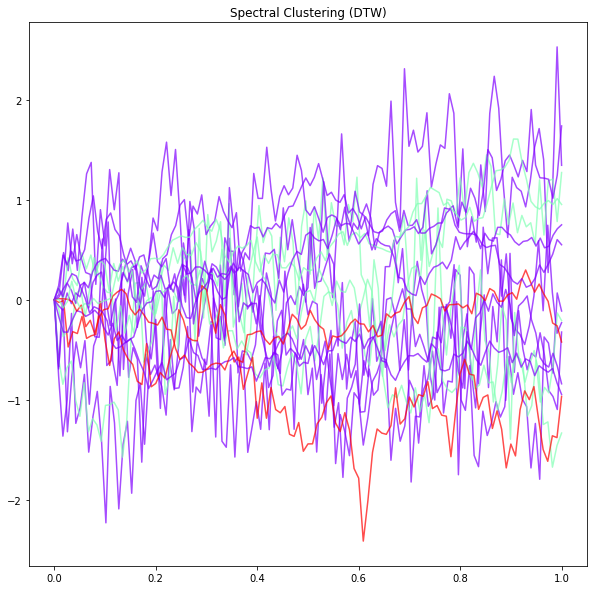

In [21]:
dtw_spectral_cluster = SpectralClustering(n_clusters=3, affinity='precomputed')

dtw_spectral_cluster.fit(df_dtw.values)

# colors map
spectral_cluster_to_colors_dict = {}
for i, c in enumerate(np.unique(dtw_spectral_cluster.labels_)):
    spectral_cluster_to_colors_dict[c] = colors[i]

# plotting
plt.figure(figsize=(10,10))
for i, (path, cluster_index, class_index) in enumerate(zip(paths, dtw_spectral_cluster.labels_, labels)):
    plt.plot(np.linspace(0,1, len(path)), path, color=spectral_cluster_to_colors_dict[cluster_index], 
             label=f'class {class_index}', alpha=0.7)
    
print_results(k, dtw_spectral_cluster.labels_, labels)

# plt.legend()
plt.title('Spectral Clustering (DTW)')
plt.show()

### Warping $p$-variation

Estimated number of clusters: 3
Homogeneity: 0.347
Completeness: 0.153
V-measure: 0.213


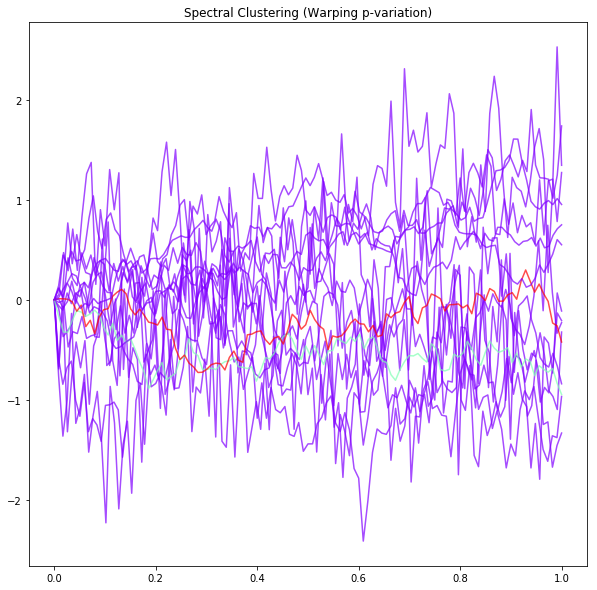

In [22]:
warp_spectral_cluster = SpectralClustering(n_clusters=3, affinity='precomputed')

warp_spectral_cluster.fit(df_warp.values)

# colors map
spectral_cluster_to_colors_dict = {}
for i, c in enumerate(np.unique(warp_spectral_cluster.labels_)):
    spectral_cluster_to_colors_dict[c] = colors[i]

# plotting
plt.figure(figsize=(10,10))
for i, (path, cluster_index, class_index) in enumerate(zip(paths, warp_spectral_cluster.labels_, labels)):
    plt.plot(np.linspace(0,1, len(path)), path, color=spectral_cluster_to_colors_dict[cluster_index], 
             label=f'class {class_index}', alpha=0.7)
    
print_results(k, warp_spectral_cluster.labels_, labels)

# plt.legend()
plt.title('Spectral Clustering (Warping p-variation)')
plt.show()

# PCA visualization

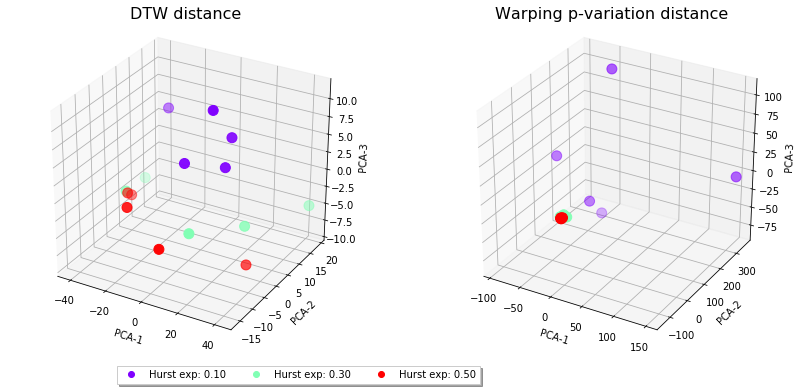

In [23]:
pca = decomposition.PCA()
pca.n_components = 3

PCA_results_dtw = pca.fit_transform(df_dtw)
PCA_results_warp = pca.fit_transform(df_warp)

# PCA_results_dtw = TSNE(n_components=3, 
#                        perplexity=2,
#                        early_exaggeration=20,
#                        learning_rate=10,
#                        init=PCA_results_dtw,
#                        metric='precomputed').fit_transform(df_dtw.values)

# PCA_results_warp = TSNE(n_components=3, 
#                         perplexity=2,
#                         early_exaggeration=20,
#                         learning_rate=10,
#                         init=PCA_results_warp,
#                         metric='precomputed').fit_transform(df_warp.values)

options = np.unique(labels)
c = []
for l in labels:
    for i,o in enumerate(options):
        if l==o:
            c.append(colors[i])

fig = plt.figure(figsize=(14,6))
fig.subplots_adjust(top=0.9)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(xs=PCA_results_dtw[:,0], ys=PCA_results_dtw[:,1], zs=PCA_results_dtw[:,2], c=c, s=100)
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')
ax.set_zlabel('PCA-3')
ax.set_title('DTW distance \n ', fontsize=16)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(xs=PCA_results_warp[:,1], 
           ys=PCA_results_warp[:,0], 
           zs=PCA_results_warp[:,2], c=c, s=100)
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')
ax.set_zlabel('PCA-3')
# ax.set_xlim(-200,20)
ax.set_title('Warping p-variation distance \n ', fontsize=16)

from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm
custom_lines = []
for j in range(k):
    custom_lines.append(Line2D([0], [0], color=colors[j], lw=4, marker='o', ls=''))

ax.legend(custom_lines, ['Hurst exp: {:.2f}'.format(l) for l in np.unique(labels)], loc=(-0.9,-0.1), ncol=5, shadow=True, fancybox=False)
# plt.subplots_adjust(top=0.1)
plt.show()